IMPORT

In [2]:
import numpy as np #добавление больших многомерных массивов и матриц и операций над ними
import matplotlib.pyplot as plt #добавление интерфейса для построения графиков простых функций
%matplotlib inline 
#построение графика непосредственно в Jupiter

from sklearn.model_selection import train_test_split #разделение датасета на train и test
from sklearn.metrics import accuracy_score, precision_score, recall_score #метрики качества

import os #взаимодействие между пользователем и операционной системой, работа с файлами и каталогами

DATASET

In [3]:
def load_planar_dataset(m=400):
    np.random.seed(1)
    N = int(m/2)
    D = 2
    X = np.zeros((m,D))
    Y = np.zeros((m,1), dtype='uint8')
    a = 4 

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y

In [4]:
def plot_decision_boundary(model, X, y):
    X = X.T
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

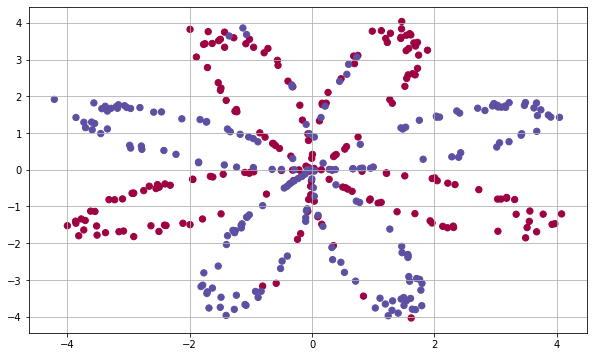

In [5]:
X, Y = load_planar_dataset() #загружаем датасет
plt.figure(figsize=(10,6))
plt.grid()
plt.scatter(X[:,0], X[:,1], c=Y[:,0], s=40, cmap=plt.cm.Spectral)

CLASS NEURALNETWORK

In [31]:
class NeuralNetwork:
    
    def __init__(self, n_input, data):
        self.data = data
        self.ni = n_input #number of input
        self.nl = len(data) #number of layers
        self.activation_funcs = set()
        self.size_layers = dict()
        self.funcs = dict()
        self.params = dict()
        self.gradients = dict()
        self.cache = dict()

        for i in range(1, self.nl + 1):
            self.funcs['func_' + str(i)] = str(data['layer_' + str(i)][1])
            self.activation_funcs.add(str(self.funcs['func_' + str(i)]))
            self.size_layers['layer_' + str(i)] = int(data['layer_' + str(i)][0])
            self.params['w' + str(i)] = None
            self.params['b' + str(i)] = None
            self.gradients['dw' + str(i)] = None
            self.gradients['db' + str(i)] = None
            self.gradients['dz' + str(i)] = None
            self.cache['z' + str(i)] = None
            self.cache['a' + str(i)] = None 
            
        self.params['w' + str(self.nl + 1)] = None
        self.params['b' + str(self.nl + 1)] = None
        self.gradients['dw' + str(self.nl + 1)] = None
        self.gradients['db' + str(self.nl + 1)] = None
        self.gradients['dz' + str(self.nl + 1)] = None
        self.cache['z' + str(self.nl + 1)] = None
        self.cache['a' + str(self.nl + 1)] = None
        self.cache['X'] = None 

        self._initialize_params()
        self._initialize_activations()

    def _initialize_params(self):
        self.params['w1'] = np.random.randn(self.size_layers['layer_1'], self.ni)
        self.params['b1'] = np.zeros(self.size_layers['layer_1'], )

        for i in range(2, self.nl + 1):
            self.params['w' + str(i)] = np.random.randn(self.size_layers['layer_' + str(i)], self.size_layers['layer_' + str(i - 1)])
            self.params['b' + str(i)] = np.zeros(self.size_layers['layer_' + str(i)],)

        self.params['w' + str(self.nl + 1)] = np.random.randn(1, self.size_layers['layer_' + str(self.nl)])
        self.params['b' + str(self.nl + 1)] = np.zeros(1, )

        for key in self.params.keys():
            self.gradients[key] = np.zeros_like(self.params[key])
            
    
    def _initialize_activations(self):
        for i,activation in enumerate(self.funcs):
            numl = i + 1
            if activation == "tanh":
                self.__dict__['activation' + str(numl)] = np.tanh
                self.__dict__['activation' + str(numl)+"_backward"] = \
                lambda x: 1 - np.tanh(x)**2
            if activation == "sigmoid":
                self.__dict__['activation' + str(numl)] = self.sigmoid
                self.__dict__['activation' + str(numl)+"_backward"] = \
                lambda x: self.sigmoid(x)*(1.-self.sigmoid(x))

In [33]:
network = NeuralNetwork(4, dict({'layer_1': [3, 'sigmoid'], 'layer_2': [3, 'tanh'], 'layer_3': [3, 'sigmoid']}))
print(network.params)

{'w1': array([[ 0.18693705, -0.25485295, -0.14091075, -0.66189183],
       [ 0.2590319 ,  0.01444842, -1.47958003, -0.2407005 ],
       [-0.85567139, -2.04820046,  0.48388365,  1.55868825]]), 'b1': array([0., 0., 0.]), 'w2': array([[ 2.36973019,  1.56241953, -0.87080155],
       [ 1.17524499,  1.119899  , -1.98782953],
       [ 0.86128852,  0.62717704,  0.16280825]]), 'b2': array([0., 0., 0.]), 'w3': array([[ 0.28861672,  0.05830738,  1.63193585],
       [-0.40178883, -0.19993939,  0.00738898],
       [ 0.27566408, -1.7632498 ,  1.38797381]]), 'b3': array([0., 0., 0.]), 'w4': array([[0.22619976, 0.5691246 , 0.19731599]]), 'b4': array([0.])}


In [20]:
class Optimizer:
    def __init__(self, regression_class, lr=1e-2):
        self.model = regression_class
        self.lr = lr
        
        
    def step(self):
        new_params = {
            k: None for k in self.model.params
        }
        params = self.model.params
        grads = self.model.gradients
        #print("PARAMS:",params)
        #print("GRADS:",grads)
        for key in self.model.params.keys():
            new_params[key] = params[key] - self.lr*grads["d"+key]
        self.model.params = new_params
        
        
    def zero_grad(self):
        for key in self.model.gradients.keys():
            self.model.gradients[key] = np.zeros_like(self.model.gradients[key])

In [21]:
class Loss:
    def __init__(self, model, loss_fn, loss_fn_bw):
        self.model = model
        self.loss_fn = loss_fn
        self.loss_fn_bw = loss_fn_bw
        self.dL = None
        self.a = None
        self.y = None
    
    
    def __call__(self, a, y):
        self.a = a
        self.y = y
        return self.loss_fn(a, y)
    
    
    def forward(self, a, y):
        return self.__call__(a, y)
    
    
    def backward(self, **params):
        assert (self.a is not None) and (self.y is not None), "loss.forward() must be called first!"
        self.dL = self.loss_fn_bw(self.a, self.y)
        self.model.backward(self.dL, **params)

        
def binary_crossentropy(a, y, eps=1e-5):
    #print(len(a))
    return -( y*np.log(eps+a) + (1. - y)*np.log(eps+1. - a)).mean()

def binary_crossentropy_bw(a, y, eps=1e-5):
    return -1./len(a)*((y-a)/ (eps+ a*(1.-a)))

In [23]:
X, y = load_planar_dataset(m=1000)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [25]:
model = OneLayerNN(n_input=2, n_hidden=32, activation_funs=['tanh', 'sigmoid'])
optimizer = Optimizer(model, lr=1e-2)
loss = Loss(model, binary_crossentropy, binary_crossentropy_bw)
model.summary()

Layer_1	 weights shape: (32, 2)	 bias shape: (32,)
Layer_2	 weights shape: (1, 32)	 bias shape: (1,)


In [27]:
num_epochs = 5000
for i in range(num_epochs):
    a = model(X_train)
    l = loss(a, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if (i % 400 == 0):
        a_val = model(X_test)
        print("Epoch %d/%d\t Loss: %.3f"%(i, num_epochs, l), end='\t')
        print("Accuracy: %.3f"%(accuracy_score(y_train, a>0.5)), end='\t')
        print("Val_loss: %.3f"%(loss(a_val, y_test)), end='\t')
        print("Val_accuracy: %.3f"%(accuracy_score(y_test, a_val>0.5)))

C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


Epoch 0/5000	 Loss: 1.382	Accuracy: 0.880	Val_loss: 4.191	Val_accuracy: 0.636
Epoch 400/5000	 Loss: 3.021	Accuracy: 0.736	Val_loss: 2.118	Val_accuracy: 0.816


C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


Epoch 800/5000	 Loss: 2.915	Accuracy: 0.745	Val_loss: 1.726	Val_accuracy: 0.844


C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


Epoch 1200/5000	 Loss: 2.030	Accuracy: 0.819	Val_loss: 1.017	Val_accuracy: 0.904


C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


Epoch 1600/5000	 Loss: 1.676	Accuracy: 0.853	Val_loss: 1.244	Val_accuracy: 0.892


C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


Epoch 2000/5000	 Loss: 2.380	Accuracy: 0.792	Val_loss: 1.986	Val_accuracy: 0.824


C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


Epoch 2400/5000	 Loss: 2.039	Accuracy: 0.823	Val_loss: 3.006	Val_accuracy: 0.736


C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


Epoch 2800/5000	 Loss: 2.192	Accuracy: 0.807	Val_loss: 1.520	Val_accuracy: 0.868


C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


Epoch 3200/5000	 Loss: 2.244	Accuracy: 0.803	Val_loss: 3.177	Val_accuracy: 0.724


C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


Epoch 3600/5000	 Loss: 2.711	Accuracy: 0.759	Val_loss: 1.816	Val_accuracy: 0.840


C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


Epoch 4000/5000	 Loss: 1.618	Accuracy: 0.857	Val_loss: 1.347	Val_accuracy: 0.876


C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


Epoch 4400/5000	 Loss: 1.667	Accuracy: 0.855	Val_loss: 1.658	Val_accuracy: 0.856


C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


Epoch 4800/5000	 Loss: 1.634	Accuracy: 0.856	Val_loss: 1.093	Val_accuracy: 0.904


C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


Decision Boundary for train, hidden layer size 32


C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


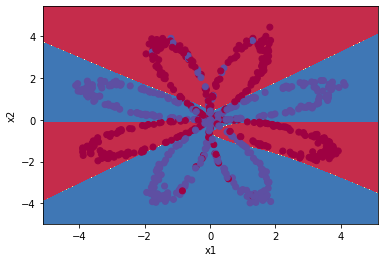

In [28]:
print("Decision Boundary for train, hidden layer size " + str(model.params['w1'].shape[0]))
plot_decision_boundary(lambda x: model(x)>0.5, X_train, y_train)

Decision Boundary for test, hidden layer size 32


C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:58: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z)),
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: overflow encountered in exp
  np.exp(z) / (1 + np.exp(z))
C:\Users\Матвей\AppData\Local\Temp\ipykernel_14400\3475941076.py:59: RuntimeWarning: invalid value encountered in divide
  np.exp(z) / (1 + np.exp(z))


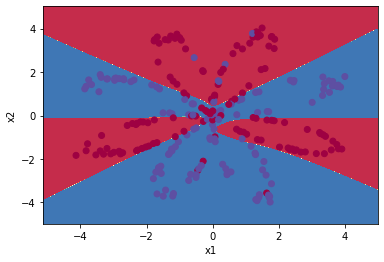

In [29]:
print("Decision Boundary for test, hidden layer size " + str(model.params['w1'].shape[0]))
plot_decision_boundary(lambda x: model(x)>0.5, X_test, y_test)